In [24]:
import os
import numpy as np
import torch 
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
import matplotlib.pyplot as plt
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score
import pickle
from pathlib import Path

1.0.0


In [25]:
import pandas as pd

In [26]:
%matplotlib inline

# IMAGE MODEL

In [27]:
# set path
training_data_path = "../data/image_data/training_data/"    # define UCF-101 RGB data path
validation_data_path = "../data/image_data/validation_data/"
test_data_path = "../data/image_data/test_data/"
save_model_path = "./ResNetCRNN_ckpt/"

# EncoderCNN architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512   # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.25    # dropout probability

# DecoderRNN architecture
RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 256

# training parameters
k = 6           # number of target category
epochs = 50       # training epochs
batch_size = 128
learning_rate = 7e-6
l_decay = 5e-4
log_interval = 10  # interval for displaying training info

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 20, 1

In [45]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.train()
    rnn_decoder.train()

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device)
        
        N_count += X.size(0)

        optimizer.zero_grad()
        output = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
        
        criterion = nn.L1Loss(reduction = 'sum')
        loss = criterion(output, y)
        losses.append(loss.item())

        # to compute accuracy
        #y_pred = torch.max(output, 1)[1]  # y_pred != output
        #step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        #scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    return losses, scores

In [46]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for (X, y) in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)

            output = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
            
            criterion = nn.L1Loss(reduction = 'sum')
            loss = criterion(output, y)
            test_loss += loss.item()                 # sum up batch loss
            #y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            #all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    #all_y = torch.stack(all_y, dim=0)
    #all_y_pred = torch.stack(all_y_pred, dim=0)
    #test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.8f}, \n'.format(len(all_y), test_loss))

    # save Pytorch models of best record
    torch.save(cnn_encoder.state_dict(), os.path.join(save_model_path, 'cnn_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(rnn_decoder.state_dict(), os.path.join(save_model_path, 'rnn_decoder_epoch{}.pth'.format(epoch + 1)))  # save motion_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss


In [30]:
def CRNN_final_prediction(model, device, loader):
    cnn_encoder, rnn_decoder = model
    cnn_encoder.eval()
    rnn_decoder.eval()

    all_y_pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            X = X.to(device)
            output = rnn_decoder(cnn_encoder(X))   # output has dim = (batch, number of classes)
            #y_pred = output.max(1, keepdim=True)[1]  # location of max log-probability as prediction
            all_y_pred.append(output)

    return all_y_pred

In [31]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU
print(device)

cuda


## Image data preparation

In [32]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}
params2 = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}

In [33]:
transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

In [34]:
with open('../data/image_data/pickle_files/y_5d_training_all.pkl', 'rb') as file:
    train_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_training.pkl', 'rb') as file:
    train_list = pickle.load(file)
    
with open('../data/image_data/pickle_files/y_5d_validation_all.pkl', 'rb') as file:
    val_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_validation.pkl', 'rb') as file:
    val_list = pickle.load(file)
    
with open('../data/image_data/pickle_files/y_5d_test_all.pkl', 'rb') as file:
    test_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_test.pkl', 'rb') as file:
    test_list = pickle.load(file)

# Begin training

In [35]:
train_set, valid_set = Dataset_CRNN(training_data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_CRNN(validation_data_path, val_list, val_label, selected_frames, transform=transform)

train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

In [36]:
test_set = Dataset_CRNN(test_data_path, test_list, test_label, selected_frames, transform=transform)
test_loader = data.DataLoader(test_set, **params2)

In [37]:
cnn_encoder = ResCNNEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)
rnn_decoder = DecoderRNN(CNN_embed_dim=CNN_embed_dim, h_RNN_layers=RNN_hidden_layers, h_RNN=RNN_hidden_nodes, 
                         h_FC_dim=RNN_FC_dim, drop_p=dropout_p, num_classes=k).to(device)

In [38]:
final_net = Final_Net(drop_p = dropout_p).to(device)

In [39]:
print("Using", torch.cuda.device_count(), "GPU!")
# Combine all EncoderCNN + DecoderRNN parameters
crnn_params = list(cnn_encoder.fc1.parameters()) + list(cnn_encoder.bn1.parameters()) + \
              list(cnn_encoder.fc2.parameters()) + list(cnn_encoder.bn2.parameters()) + \
              list(cnn_encoder.fc3.parameters()) + list(rnn_decoder.parameters())

Using 3 GPU!


In [40]:
optimizer = torch.optim.Adam(
            [
                {"params": cnn_encoder.resnet.parameters(), "lr": 1e-6},
                {"params": crnn_params}
            ],
            lr=learning_rate)

In [41]:
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

In [ ]:
for epoch in range(epochs):
    # train, test model
    if __name__ == '__main__':
        train_losses, train_scores = train(log_interval, [cnn_encoder, rnn_decoder], device, train_loader, optimizer, epoch)
        epoch_test_loss = validation([cnn_encoder, rnn_decoder], device, optimizer, test_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_train_scores.append(train_scores)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    np.save('./CRNN_epoch_training_losses.npy', A)
    np.save('./CRNN_epoch_test_loss.npy', C)

Train Epoch: 1 [1280/6000 (21%)]	Loss: 54.970566
Train Epoch: 1 [2560/6000 (43%)]	Loss: 57.148220
Train Epoch: 1 [3840/6000 (64%)]	Loss: 51.365261
Train Epoch: 1 [5120/6000 (85%)]	Loss: 51.518131

Test set (2000 samples): Average loss: 0.58277439, 

Epoch 1 model saved!
Train Epoch: 2 [1280/6000 (21%)]	Loss: 53.027069
Train Epoch: 2 [2560/6000 (43%)]	Loss: 52.080971
Train Epoch: 2 [3840/6000 (64%)]	Loss: 51.864014
Train Epoch: 2 [5120/6000 (85%)]	Loss: 54.606243

Test set (2000 samples): Average loss: 0.58588967, 

Epoch 2 model saved!
Train Epoch: 3 [1280/6000 (21%)]	Loss: 49.806267
Train Epoch: 3 [2560/6000 (43%)]	Loss: 50.987175
Train Epoch: 3 [3840/6000 (64%)]	Loss: 52.715179
Train Epoch: 3 [5120/6000 (85%)]	Loss: 51.381561

Test set (2000 samples): Average loss: 0.58813618, 

Epoch 3 model saved!
Train Epoch: 4 [1280/6000 (21%)]	Loss: 55.628841
Train Epoch: 4 [2560/6000 (43%)]	Loss: 60.013023
Train Epoch: 4 [3840/6000 (64%)]	Loss: 51.213821
Train Epoch: 4 [5120/6000 (85%)]	Loss: 5

In [ ]:
test_set = Dataset_CRNN(test_data_path, test_list, test_label, selected_frames, transform=transform)
test_loader = data.DataLoader(test_set, **params2)

In [42]:
cnn_encoder.load_state_dict(torch.load(os.path.join(save_model_path, 'cnn_encoder_epoch10.pth')))
rnn_decoder.load_state_dict(torch.load(os.path.join(save_model_path, 'rnn_decoder_epoch10.pth')))

In [79]:
all_y_pred = CRNN_final_prediction([cnn_encoder, rnn_decoder], device, test_loader)

100%|██████████| 63/63 [01:14<00:00,  1.19s/it]


In [80]:
preds = np.zeros((2000,6))
k = 0
for i in range(len(all_y_pred)):
    for j in range(len(all_y_pred[i])):
        batch_pred = all_y_pred[i].cpu()
        preds[k] = batch_pred[j]
        k +=1

In [81]:
print(preds)

[[0.52528113 0.47713935 0.56478775 0.54865766 0.53525519 0.55902994]
 [0.40809232 0.38457096 0.48803568 0.42725697 0.42693549 0.47648066]
 [0.50756526 0.46386525 0.56816781 0.52261978 0.5219897  0.55389333]
 ...
 [0.59813333 0.59519273 0.59381807 0.60859209 0.62060815 0.68117052]
 [0.5947057  0.51854926 0.62815386 0.62048274 0.59751427 0.59946895]
 [0.36433494 0.34954178 0.45114994 0.38957319 0.3871204  0.45422906]]


In [82]:
print(test_label)

[[0.41121495 0.42990654 0.50549451 0.45631068 0.53125    0.46666667]
 [0.3271028  0.27102804 0.47252747 0.31067961 0.33333333 0.43333333]
 [0.4953271  0.35514019 0.52747253 0.67961165 0.39583333 0.45555556]
 ...
 [0.6728972  0.53271028 0.54945055 0.73786408 0.63541667 0.81111111]
 [0.57009346 0.40186916 0.65934066 0.55339806 0.53125    0.54444444]
 [0.41121495 0.28037383 0.50549451 0.48543689 0.35416667 0.37777778]]


# Eval Metrics IMAGE

In [83]:
acc = np.zeros(6)
for i in range(6):
    ind = i
    diff = abs(preds[:,ind] - test_label[:, ind])

    acc[i] = 1-(np.sum(diff))/2000

print(acc)
print(np.mean(acc))

[0.90598967 0.89957138 0.90615072 0.90091895 0.89888316 0.90227199]
0.9022976455721116


In [49]:
ind = 0

diff = abs(preds[:,ind] - test_label[:, ind])
avg = np.mean(test_label[:, ind])
print(avg)
avg_diff = abs(test_label[:, ind] - avg)

acc = 1 - ((np.sum(diff))/np.sum(avg_diff))/2000
print(acc)

0.5073738317757008
0.9996010760463486


IndexError: too many indices for array

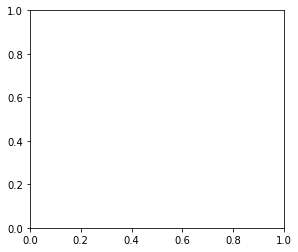

In [87]:
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(np.arange(1, epochs + 1), A[:, -1])  # train loss (on epoch end)
plt.plot(np.arange(1, epochs + 1), C)         #  test loss (on epoch end)
plt.title("model loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc="upper left")

# RESNET MODEL

In [3]:
# set path
training_data_path = "../data/image_data/training_data/"    # define UCF-101 RGB data path
validation_data_path = "../data/image_data/validation_data/"
test_data_path = "../data/image_data/test_data/"
save_model_path = "./ResNetCRNN_ckpt/"

# ResnetEncoder architecture
CNN_fc_hidden1, CNN_fc_hidden2 = 1024, 768
CNN_embed_dim = 512   # latent dim extracted by 2D CNN
res_size = 224        # ResNet image size
dropout_p = 0.25    # dropout probability

# Not of use here
RNN_hidden_layers = 3
RNN_hidden_nodes = 512
RNN_FC_dim = 128

# training parameters
k = 6           # number of target category
epochs = 50       # training epochs
batch_size = 32
learning_rate = 1e-5
l_decay = 5e-4
log_interval = 10  # interval for displaying training info

# Select which frame to begin & end in videos
begin_frame, end_frame, skip_frame = 1, 10, 1

In [46]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    # set model as training mode
    resnet_encoder = model

    losses = []
    scores = []
    N_count = 0   # counting total trained sample in one epoch
    for batch_idx, (X, y) in enumerate(train_loader):
        # distribute data to device
        X, y = X.to(device), y.to(device)
        
        N_count += X.size(0)

        optimizer.zero_grad()
        video_output = resnet_encoder(X)   # output has dim = (batch, number of classes)
        
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(video_output, y))
        losses.append(loss.item())

        # to compute accuracy
        #y_pred = torch.max(output, 1)[1]  # y_pred != output
        #step_score = accuracy_score(y.cpu().data.squeeze().numpy(), y_pred.cpu().data.squeeze().numpy())
        #scores.append(step_score)         # computed on CPU

        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))

    return losses, scores

In [47]:
def validation(model, device, optimizer, test_loader):
    # set model as testing mode
    resnet_encoder = model

    test_loss = 0
    all_y = []
    all_y_pred = []
    with torch.no_grad():
        for (X, y) in test_loader:
            # distribute data to device
            X, y = X.to(device), y.to(device)

            video_output = resnet_encoder(X)   # output has dim = (batch, number of classes)

            criterion = nn.MSELoss()
            loss = torch.sqrt(criterion(video_output, y))
            test_loss += loss.item()                 # sum up batch loss
            #y_pred = output.max(1, keepdim=True)[1]  # (y_pred != output) get the index of the max log-probability

            # collect all y and y_pred in all batches
            all_y.extend(y)
            #all_y_pred.extend(y_pred)

    test_loss /= len(test_loader.dataset)

    # compute accuracy
    #all_y = torch.stack(all_y, dim=0)
    #all_y_pred = torch.stack(all_y_pred, dim=0)
    #test_score = accuracy_score(all_y.cpu().data.squeeze().numpy(), all_y_pred.cpu().data.squeeze().numpy())

    # show information
    print('\nTest set ({:d} samples): Average loss: {:.4f}, \n'.format(len(all_y), test_loss))

    # save Pytorch models of best record
    torch.save(resnet_encoder.state_dict(), os.path.join(save_model_path, 'resnet_encoder_epoch{}.pth'.format(epoch + 1)))  # save spatial_encoder
    torch.save(optimizer.state_dict(), os.path.join(save_model_path, 'optimizer_resnet_epoch{}.pth'.format(epoch + 1)))      # save optimizer
    print("Epoch {} model saved!".format(epoch + 1))

    return test_loss


In [48]:
def CRNN_final_prediction(model, device, loader):
    resnet_encoder = model

    all_y_pred = []
    with torch.no_grad():
        for batch_idx, (X, y) in enumerate(tqdm(loader)):
            # distribute data to device
            X = X.to(device)
            video_output = resnet_encoder(X)   # output has dim = (batch, number of classes)
            #y_pred = output.max(1, keepdim=True)[1]  # location of max log-probability as prediction
            all_y_pred.append(video_output)

    return all_y_pred

In [49]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU
print(device)

cuda


In [50]:
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}
params2 = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 0, 'pin_memory': True} if use_cuda else {}

In [51]:
transform = transforms.Compose([transforms.Resize([res_size, res_size]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                
                               ])

selected_frames = np.arange(begin_frame, end_frame, skip_frame).tolist()

with open('../data/image_data/pickle_files/y_5d_training_all.pkl', 'rb') as file:
    train_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_training.pkl', 'rb') as file:
    train_list = pickle.load(file)
    
with open('../data/image_data/pickle_files/y_5d_validation_all.pkl', 'rb') as file:
    val_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_validation.pkl', 'rb') as file:
    val_list = pickle.load(file)
    
with open('../data/image_data/pickle_files/y_5d_test_all.pkl', 'rb') as file:
    test_label = pickle.load(file)

with open('../data/image_data/pickle_files/vid_ids_5d_test.pkl', 'rb') as file:
    test_list = pickle.load(file)

In [52]:
train_set, valid_set = Dataset_Resnet(training_data_path, train_list, train_label, selected_frames, transform=transform), \
                       Dataset_Resnet(validation_data_path, val_list, val_label, selected_frames, transform=transform)

train_loader = data.DataLoader(train_set, **params)
valid_loader = data.DataLoader(valid_set, **params)

In [53]:
test_set = Dataset_Resnet(test_data_path, test_list, test_label, selected_frames, transform=transform)
test_loader = data.DataLoader(test_set, **params2)

In [54]:
resnet_encoder = ResnetEncoder(fc_hidden1=CNN_fc_hidden1, fc_hidden2=CNN_fc_hidden2, drop_p=dropout_p, CNN_embed_dim=CNN_embed_dim).to(device)

In [55]:
print("Using", torch.cuda.device_count(), "GPU!")
# Combine all EncoderCNN + DecoderRNN parameters
resnet_params = list(resnet_encoder.fc1.parameters()) + list(resnet_encoder.bn1.parameters()) + \
              list(resnet_encoder.fc2.parameters()) + list(resnet_encoder.bn2.parameters()) + \
              list(resnet_encoder.fc3.parameters()) + list(resnet_encoder.fc4.parameters()) + list(resnet_encoder.fc5.parameters())

Using 3 GPU!


In [56]:
optimizer = torch.optim.Adam(resnet_params, lr=learning_rate)

In [57]:
epoch_train_losses = []
epoch_train_scores = []
epoch_test_losses = []
epoch_test_scores = []

In [65]:
for epoch in range(epochs):
    # train, test model
    if __name__ == '__main__':
        train_losses, train_scores = train(log_interval, resnet_encoder, device, train_loader, optimizer, epoch)
        epoch_test_loss = validation(resnet_encoder, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(epoch_test_loss)

    # save all train test results
    A = np.array(epoch_train_losses)
    C = np.array(epoch_test_losses)
    np.save('./CRNN_epoch_training_lossesMAE.npy', A)
    np.save('./CRNN_epoch_test_lossMAE.npy', C)

Train Epoch: 1 [320/6000 (5%)]	Loss: 0.129187
Train Epoch: 1 [640/6000 (11%)]	Loss: 0.138105
Train Epoch: 1 [960/6000 (16%)]	Loss: 0.133177
Train Epoch: 1 [1280/6000 (21%)]	Loss: 0.131702
Train Epoch: 1 [1600/6000 (27%)]	Loss: 0.129968
Train Epoch: 1 [1920/6000 (32%)]	Loss: 0.103351
Train Epoch: 1 [2240/6000 (37%)]	Loss: 0.141724
Train Epoch: 1 [2560/6000 (43%)]	Loss: 0.118666
Train Epoch: 1 [2880/6000 (48%)]	Loss: 0.110001
Train Epoch: 1 [3200/6000 (53%)]	Loss: 0.119945
Train Epoch: 1 [3520/6000 (59%)]	Loss: 0.143460
Train Epoch: 1 [3840/6000 (64%)]	Loss: 0.133383
Train Epoch: 1 [4160/6000 (69%)]	Loss: 0.129440
Train Epoch: 1 [4480/6000 (74%)]	Loss: 0.113232
Train Epoch: 1 [4800/6000 (80%)]	Loss: 0.116389
Train Epoch: 1 [5120/6000 (85%)]	Loss: 0.116457
Train Epoch: 1 [5440/6000 (90%)]	Loss: 0.124644
Train Epoch: 1 [5760/6000 (96%)]	Loss: 0.118416

Test set (2000 samples): Average loss: 0.0041, 

Epoch 1 model saved!
Train Epoch: 2 [320/6000 (5%)]	Loss: 0.129512
Train Epoch: 2 [640/600

KeyboardInterrupt: 

In [120]:
resnet_encoder.load_state_dict(torch.load(os.path.join(save_model_path, 'resnet_encoder_epoch43.pth')))

In [121]:
all_y_pred = CRNN_final_prediction(resnet_encoder, device, test_loader)

100%|██████████| 63/63 [00:07<00:00,  8.92it/s]


In [122]:
preds = np.zeros((2000,6))
k = 0
for i in range(len(all_y_pred)):
    for j in range(len(all_y_pred[i])):
        batch_pred = all_y_pred[i].cpu()
        preds[k] = batch_pred[j]
        k +=1

In [123]:
print(preds)

[[0.61028981 0.58072871 0.61593825 0.71433711 0.63749462 0.66685444]
 [0.55970967 0.55023348 0.57460058 0.55090833 0.58938539 0.57664657]
 [0.45658562 0.41326034 0.54161274 0.48947003 0.46061429 0.49897346]
 ...
 [0.65526438 0.57461441 0.58798432 0.67181104 0.67036235 0.75111884]
 [0.47208357 0.42950732 0.54061741 0.55071718 0.49810818 0.56203741]
 [0.24775676 0.19362608 0.39594135 0.385773   0.28244293 0.30333051]]


In [124]:
print(test_label)

[[0.41121495 0.42990654 0.50549451 0.45631068 0.53125    0.46666667]
 [0.3271028  0.27102804 0.47252747 0.31067961 0.33333333 0.43333333]
 [0.4953271  0.35514019 0.52747253 0.67961165 0.39583333 0.45555556]
 ...
 [0.6728972  0.53271028 0.54945055 0.73786408 0.63541667 0.81111111]
 [0.57009346 0.40186916 0.65934066 0.55339806 0.53125    0.54444444]
 [0.41121495 0.28037383 0.50549451 0.48543689 0.35416667 0.37777778]]


In [125]:
acc = np.zeros(6)
for i in range(6):
    ind = i
    diff = abs(preds[:,ind] - test_label[:, ind])

    acc[i] = 1-(np.sum(diff))/2000

print(acc)
print(np.mean(acc))

[0.90467691 0.898808   0.90380771 0.90391984 0.89706602 0.90127052]
0.9015915009204183
